In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from psmiles import PolymerSmiles as PS
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import ast

random_seed = 123
torch.manual_seed(random_seed)
np.random.seed(random_seed)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_pickle("../../data/updated_polymers.pth")

In [3]:
scalar = MinMaxScaler()
data = df["fingerprint_polyBERT"]
target = df["Egc"]

#data = data.values.reshape(-1, 1)  # Reshape data

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=123)

# Scaling target variable
target_train = scalar.fit_transform(target_train.values.reshape(-1, 1))
target_test = scalar.transform(target_test.values.reshape(-1, 1))

# Creating tensors from data

#Training Data
data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)
target_train_tensor = torch.tensor(target_train, dtype=torch.float32)

train_dataset = TensorDataset(data_train_tensor, target_train_tensor)
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle= True)

#Testing Data

data_test_tensor = torch.tensor(data_test.reset_index(drop= True), dtype=torch.float32)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32)

test_dataset = TensorDataset(data_test_tensor, target_test_tensor)
test_loader = DataLoader(test_dataset, shuffle= False)

/tmp/ipykernel_3267934/2183922834.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)


In [4]:
class MTmodel(nn.Module):
    def __init__(self):
        super(MTmodel, self).__init__()
        self.my_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(600, 1504),
                nn.Dropout(0.122517721),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1504, 1760),
                nn.Dropout(0.125659318),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1760, 928),
                nn.Dropout(0.23314474976099792),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(928, 800),
                nn.Dropout(0.43785063341512964),
                nn.PReLU()
            ),
            nn.Linear(800,1)
        ])
    
    def forward(self, x):
        for layer_step in self.my_layers:
            x = layer_step(x)
        return x

In [5]:
state_dict = torch.load('../../models/molecule_polyBERT.pth')

In [6]:
net = MTmodel()
(net.my_layers[0][0].weight).values = state_dict['my_layers.0.0.weight']
(net.my_layers[0][0].bias).values = state_dict['my_layers.0.0.bias']
(net.my_layers[0][2].weight).values = state_dict['my_layers.0.2.weight']
(net.my_layers[1][0].weight).values = state_dict['my_layers.1.0.weight']
(net.my_layers[1][0].bias).values = state_dict['my_layers.1.0.bias']
(net.my_layers[1][2].weight).values = state_dict['my_layers.1.2.weight']

for name, param in net.named_parameters():
        if '0.0' in name or '0.2' in name or '1.0' in name or '1.2' in name:
            param.requires_grad = False

net = net.to(DEVICE)
            
optimizer = optim.Adam(net.parameters(), lr =  0.00020108)


EPOCHS = 395
losses = []
for epoch in range(EPOCHS):
  running_loss = 0.0
  correct = 0
  for batch_idx,(data, target) in enumerate(train_loader):

    data, target = data.to(DEVICE), target.view(-1).to(DEVICE)
    optimizer.zero_grad()
    output = net(data)
    loss = F.mse_loss(output.view(-1), target)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / batch_idx
  losses.append(epoch_loss)

  # Print epoch loss
  print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

[0.01754269160751608, 0.007476373301220259, 0.006563751074108517, 0.006454706247452469, 0.006048698119619595, 0.0058855188156788545, 0.0055161763517563005, 0.005615727152741913, 0.005581333141197406, 0.005685631246749489, 0.0049492178202074555, 0.004849370568990707, 0.004693359729745204, 0.0045258343757484994, 0.00466790399791318, 0.004224940314001981, 0.004663758334659394, 0.004292937182721549, 0.004210569848683441, 0.004190520412521437, 0.004244735971691885, 0.003848323992098726, 0.0037322253767689247, 0.0038347612135112286, 0.0036395389345541063, 0.003769814305650514, 0.0036019109469461476, 0.003789426334800997, 0.0033451369007317616, 0.003323415133525573, 0.003287727643813317, 0.0030909444571339656, 0.0034027493398060046, 0.003104238294153696, 0.0031865045131694173, 0.00321327077247025, 0.002988943684613332, 0.003013245809900885, 0.00297291010723538, 0.0029288738449048694, 0.0029678188369698113, 0.0027769461913045405, 0.0028344705434782164, 0.002916509199643596, 0.00287281132824275

mse: 0.29816195904722276, rmse: 0.5460420854176194, r2_score: 0.84542364896056


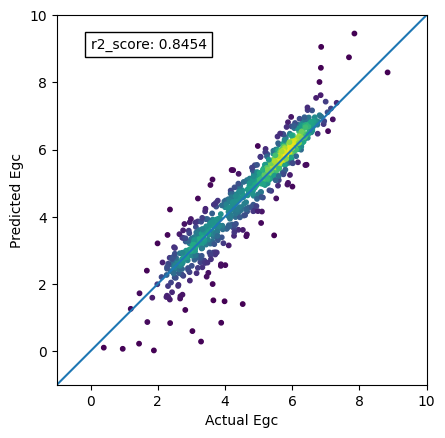

In [8]:
from scipy.stats import gaussian_kde

# Plot predictions vs. true values
@torch.no_grad()
def graphPredictions(model, data_loader , minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    model = model
    loss = []
    

    for (data,target) in (test_loader):
        # Single forward pass
        data, target =  data.to(DEVICE), target.to(DEVICE)
        pred = model(data)                              
        
        # Un-normalize our prediction
        pred = scalar.inverse_transform(pred.cpu().numpy())
        pred = torch.from_numpy(pred)
        target_cpu = scalar.inverse_transform(target.cpu().numpy())
        act = torch.from_numpy(target_cpu)
        loss = F.mse_loss(pred, act)

        # Save prediction and actual label
        predictions.append(tensor.cpu().item() for tensor in pred)
        actual.append(tensor.cpu().item() for tensor in act)


    #print(f"predictions: {predictions}, actual: {actual}")
    pred_list = [item for sublist in predictions for item in sublist]
    act_list = [item for sublist in actual for item in sublist]

    
    mse = mean_squared_error(pred_list, act_list)
    rmse = mean_squared_error(pred_list, act_list, squared = False)
    r2 = r2_score(pred_list, act_list)
    print(f"mse: {mse}, rmse: {rmse}, r2_score: {r2}")

    # Calculate the point density
    xy = np.vstack([pred_list,act_list])
    z = gaussian_kde(xy)(xy)
    
    # Plot actuals vs predictions
    plt.scatter(pred_list, act_list, s= 10, c=z)
    plt.xlabel('Actual Egc')
    plt.ylabel('Predicted Egc')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    text_x = 0
    text_y = 9
    plt.text(text_x, text_y, f"r2_score: {round(r2, 4)}", fontsize=10, bbox=dict(facecolor='white', alpha=1))
    plt.show()


graphPredictions(net, test_loader, -1, 10)